In [71]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import pandas as pd
from collections import defaultdict

## Single round

### Helper functions

In [72]:
# generates all subsets of [p] with cardinality at most k
def all_sets(p, k):
    if k==0:
        return [[]]
    if p==1:
        return [[],[0]]
    prev = all_sets(p-1, k)
    ans = []
    ans.extend(prev)
    for x in prev:
        if len(x)<k:
            ans.append(x+[p-1])
    ans.sort(key = lambda x:(len(x),x))  
    return ans

# randomly generates n x M design matrix using given dosage
def makeX(d, n, k, interactions):
    p = len(d)
    X = []
    for _ in range(n):
        vals = [2*np.random.binomial(1, d[i])-1 for i in range(p)]
        row = []
        for S in interactions:
            row.append(int(np.prod([vals[i] for i in S])))
        X.append(row)
    return X

# checks if the given dosage has all coordinates in [0,1]
def isValid(d):
    if d == []:
        return False
    return all([0<=d[i]<=1 for i in range(len(d))])

### Main function

In [80]:
# Inputs:
# p: number of treatments
# n: number of observations per round
# k: highest-order interactions (k=2 for pairwise)
# sigma: std of noise in observations
# beta_l, beta_h: each coordinate of beta sampled uniformly from (beta_l, beta_h)
# dists: for each distance in dists, dosages are sampled from this distance away from half
# trials: number of trials for each distance in dists

# Output: dictionary, length is 1+len(dists)
# One (key, value) pair that stores beta 
# key: element of dists. value: list of L2 errors for each generated dosage (length is trials)
def single_round_distances(p, n, k, sigma, beta_l, beta_h, dists, trials):
    M = sum([int(sp.special.binom(p, i)) for i in range(k+1)])
    half = np.array([.5]*p) 
    beta = np.random.uniform(low = beta_l, high = beta_h, size = M)
    K = max(np.abs(beta_l),np.abs(beta_h))**2*M
    interactions = all_sets(p,k)

    # generates d such that ||d - half|| = x
    def generate_d(x, center = .5, norm = "inf"):
        d = []
        if norm == "inf":
            d.append(center+(2*np.random.binomial(1, .5)-1)*x)
            d.extend(np.random.uniform(low = center-x, high = center+x, size = p-1))
        elif norm == 2:
            while not isValid(d):
                r = np.random.normal(loc = 0, scale = 1, size = p)
                d = [center+x*r[i]/np.linalg.norm(r) for i in range(p)]
        return d

    # carry out a single round
    def single_round(d):
        X = makeX(d, n, k, interactions)
        y = np.matmul(X, np.reshape(beta,(M,1)))+np.random.normal(loc = 0, scale = sigma, size = (n,1))
        XTX = np.matmul(np.transpose(X), X)
    
        evals = np.round(np.linalg.eigvalsh(XTX), 10)
        min_ev = min(evals)
        if min_ev==0:
            ols_bound = float('inf')
            ridge_bound = K
            method = "ridge"
            beta_hat = [0]*M
        else:
            ols_bound = M*sigma**2/min_ev
            ridge_bound = K*M*n*sigma**2/(K*min_ev**2+M*n*sigma**2)
            
            if ols_bound<ridge_bound:
                method = "ols"
                reg = LinearRegression(fit_intercept = False).fit(X, y)
                beta_hat = reg.coef_
            else:
                method = "ridge"
                lambda_ridge = sigma**2*M*n/(K*min_ev)
                clf = Ridge(alpha=lambda_ridge, fit_intercept = False)
                clf.fit(X, y)
                beta_hat = clf.coef_
        return np.linalg.norm(beta-beta_hat)**2

    # run single_round, for given distances
    results = defaultdict(list) 
    for x in dists:
        for _ in range(trials):
            d = generate_d(x)
            error = single_round(d)
            results[x].append(error)
    results["beta"] = beta
    
    return results

In [74]:
dists = np.arange(0, .4, .02)
results_single_round = single_round_distances(p = 5, n = 100, k = 2, sigma = 1, beta_l = -1, beta_h = 1, dists = dists, trials = 300)

Text(0, 0.5, 'Mean L2 error')

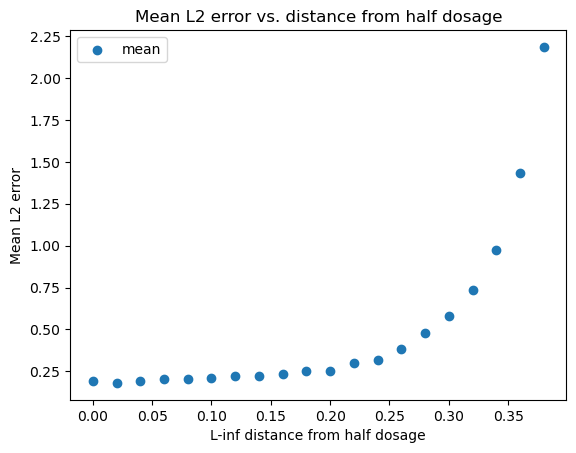

In [75]:
plt.scatter(dists, [np.mean(results_single_round[x]) for x in dists], label = "mean")
#plt.scatter(max_dists, [np.quantile(results_single_round[x], .75) for x in max_dists], label="75th")
#plt.scatter(max_dists, [np.quantile(results_single_round[x], .25) for x in max_dists], label="25th")

plt.legend()
plt.title("Mean L2 error vs. distance from half dosage")
plt.xlabel("L-inf distance from half dosage")
plt.ylabel("Mean L2 error")

### Uniform dosages

In [79]:
# Inputs:
# p, n, k, sigma: problem parameters (k is highest-order interaction)
# beta_l, beta_h: each coordinate of beta sampled uniformly from (beta_l, beta_h)
# ds: values of dosages. We will consider uniform dosages, with values in d
# trials: number of trials for each distance in dists

# Output: dictionary, length is 1+len(dists)
# One (key, value) pair that stores beta 
# key: element of ds. value: list of L2 errors for each trial (length is trials)
def single_round_uniform(p, n, k, sigma, beta_l, beta_h, ds, trials):
    M = sum([int(sp.special.binom(p, i)) for i in range(k+1)])
    half = np.array([.5]*p) 
    beta = np.random.uniform(low = beta_l, high = beta_h, size = M)
    K = max(np.abs(beta_l),np.abs(beta_h))**2*M
    interactions = all_sets(p,k)

    # carry out a single round
    def single_round(d):
        X = makeX(d, n, k, interactions)
        y = np.matmul(X, np.reshape(beta,(M,1)))+np.random.normal(loc = 0, scale = sigma, size = (n,1))
        XTX = np.matmul(np.transpose(X), X)
    
        evals = np.round(np.linalg.eigvalsh(XTX), 10)
        min_ev = min(evals)
        if min_ev==0:
            ols_bound = float('inf')
            ridge_bound = K
            method = "ridge"
            beta_hat = [0]*M
        else:
            ols_bound = M*sigma**2/min_ev
            ridge_bound = K*M*n*sigma**2/(K*min_ev**2+M*n*sigma**2)
            
            if ols_bound<ridge_bound:
                method = "ols"
                reg = LinearRegression(fit_intercept = False).fit(X, y)
                beta_hat = reg.coef_
            else:
                method = "ridge"
                lambda_ridge = sigma**2*M*n/(K*min_ev)
                clf = Ridge(alpha=lambda_ridge, fit_intercept = False)
                clf.fit(X, y)
                beta_hat = clf.coef_
        return np.linalg.norm(beta-beta_hat)**2

    # run single_round, for given distances
    results = defaultdict(list) 
    for x in ds:
        for _ in range(trials):
            d = [x]*p
            error = single_round(d)
            results[x].append(error)
    results["beta"] = beta
    
    return results

In [69]:
ds = np.arange(.4, .61, .02)
results_uniform = single_round_uniform(p = 10, n = 1000, k = 2, sigma = 1, beta_l = -1, beta_h = 1, ds = ds, trials = 100)

Text(0, 0.5, 'Average squared error')

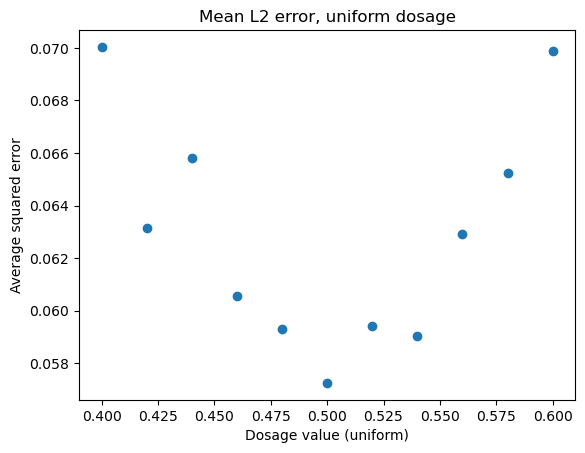

In [70]:
plt.scatter(ds, [np.mean(results_uniform[x]) for x in ds])
plt.title("Mean L2 error, uniform dosage")
plt.xlabel("Dosage value (uniform)")
plt.ylabel("Average squared error")

## Multiple rounds

In [76]:
# Inputs:
# p, n, k, sigma, beta_l, beta_h: as in single round
# d_0: initial dosage used to form first round observations
# num_rounds: number of rounds
# trials: number of times we repeat this procedure
# method: can be either "optimal" (our method) 
#                       "half" (choose half dosage every round) 
#                       "random" (choose random dosage, each coordinate U(0,1))

# Output: dictionary, length is 1+num_rounds
# One (key, value) pair is to store beta
# key: round number. value: list of L2 errors at this round (length is trials)

def multiple_round(p, n, k, sigma, beta_l, beta_h, d0, num_rounds, trials, method):
    M = sum([int(sp.special.binom(p, i)) for i in range(k+1)])
    half = np.array([.5]*p) 
    beta = np.random.uniform(low = beta_l, high = beta_h, size = M)
    K = max(np.abs(l),np.abs(h))**2*M
    interactions = all_sets(p,k)

    # computes new optimal dosage by maximizing minimum eigenvalue of new design matrix
    def new_d(P):
        def f(d):
            evals = np.linalg.eigvalsh(makeSigma(d)+P)
            return -min(evals)
        res = sp.optimize.minimize(f, x0 = half, method = 'SLSQP', bounds = [(0,1)]*p)
        return res.x

    # computes Sigma for given dosage
    def makeSigma(d):
        A = np.zeros((M,M))
        for i in range(M):
            for j in range(M):
                A[i][j] = np.prod([2*d[l]-1 for l in set(interactions[i]).symmetric_difference(set(interactions[j]))])
        return A

    # carries out regression, given the observations for all rounds so far
    def multiple_round(X, y):
        n = len(X)
        XTX = np.matmul(np.transpose(X), X)
    
        evals = np.round(np.linalg.eigvalsh(XTX), 10)
        min_ev = min(evals)
        if min_ev==0:
            ols_bound = float('inf')
            ridge_bound = K
            method = "ridge"
            beta_hat = [0]*M
        else:
            ols_bound = M*sigma**2/min_ev
            ridge_bound = K*M*n*sigma**2/(K*min_ev**2+M*n*sigma**2)
            
            if ols_bound<ridge_bound:
                method = "ols"
                reg = LinearRegression(fit_intercept = False).fit(X, y)
                beta_hat = reg.coef_
            else:
                method = "ridge"
                lambda_ridge = sigma**2*M*n/(K*min_ev)
                clf = Ridge(alpha=lambda_ridge, fit_intercept = False)
                clf.fit(X, y)
                beta_hat = clf.coef_
        return np.linalg.norm(beta-beta_hat)**2

    results = defaultdict(list)

    # runs multiple_rounds
    for _ in range(trials):
        X = makeX(d0, n, k, interactions)
        y = list(np.matmul(X, np.reshape(beta,(M,1)))+np.random.normal(loc = 0, scale = sigma, size = (n,1)))
        for r in range(num_rounds):
            error = multiple_round(X, y)
            results[r].append(error)
            P = 1/n*np.matmul(np.transpose(X), X)
            if method == "optimal":
                d = list(new_d(P))
            elif method == "half":
                d = half
            elif method == "random":
                d = np.random.uniform(low = 0, high = 1, size = p)
            else:
                raise Exception("Not a valid acquisition method")
            new_X = makeX(d, n, k, interactions)
            X.extend(new_X)
            y.extend(list(np.matmul(new_X, np.reshape(beta,(M,1)))+np.random.normal(loc = 0, scale = sigma, size = (n,1))))
    results["beta"] = beta
    return results

In [77]:
p = 5
n = 100
k = 2
sigma = 1
beta_l = -1
beta_h = -1
d0 = [.5]*p
num_rounds = 5
trials = 30

results_multiround_optimal = multiple_round(p, n, k, sigma, beta_l, beta_h, d0, num_rounds, trials, "optimal")
results_multiround_half = multiple_round(p, n, k, sigma, beta_l, beta_h, d0, num_rounds, trials, "half")
results_multiround_random = multiple_round(p, n, k, sigma, beta_l, beta_h, d0, num_rounds, trials, "random")

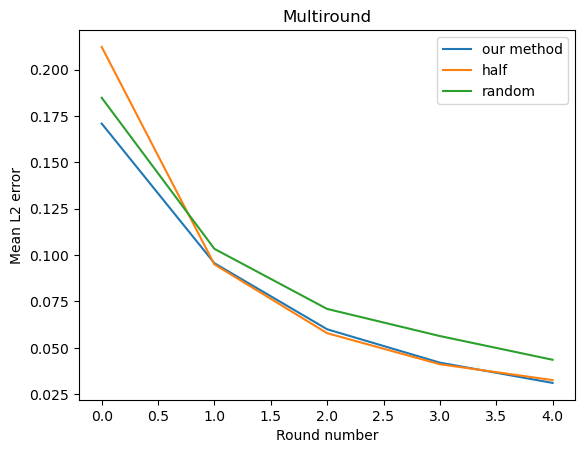

In [78]:
plt.plot(range(num_rounds), [np.mean(results_multiround_optimal[r]) for r in range(num_rounds)], label="our method")
plt.plot(range(num_rounds), [np.mean(results_multiround_half[r]) for r in range(num_rounds)], label="half")
plt.plot(range(num_rounds), [np.mean(results_multiround_random[r]) for r in range(num_rounds)], label="random")

plt.title("Multiround")
plt.xlabel("Round number")
plt.ylabel("Mean L2 error")
plt.legend()

### Other things to implement:
- Unequal variance
- Real datasets